In [9]:
#Data preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler

#Data preprocessing
data = pd.read_csv('LoanStats3b.csv',skiprows=1,low_memory=False)
data = data.drop([data.index[len(data)-1], data.index[len(data)-2]])
c = []
#Dropping columns filled with more than half null values
data = data.dropna(thresh = len(data)*9/10,axis=1)
#Removing redundant and irrelevant columns
#Removing columns which have same values throughout
del_col = ['funded_amnt_inv','emp_title','pymnt_plan','title','zip_code','out_prncp','out_prncp_inv','funded_amnt','total_pymnt_inv','policy_code','application_type','delinq_amnt','hardship_flag','debt_settlement_flag','earliest_cr_line','last_pymnt_d','last_credit_pull_d','revol_util']
data = data.drop(labels = del_col,axis=1)

#Removing percentage from rate
#Selecting month from date and no of months from term
data.iloc[:,2] = data.iloc[:,2].apply(lambda x: float(x[:-1]))
data.iloc[:,1] = data.iloc[:,1].apply(lambda x: float(x[:-7]))
data.iloc[:,10] = data.iloc[:,10].apply(lambda x:(x[:-5]))

#Converting employed length to numerical form
data["emp_length"] = data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
data["emp_length"] = data["emp_length"].apply(lambda x:float(x))
#Converting months to numerical form
month = {'Jan':1, 'Feb':2,'Mar':3, 'Apr':4, 'May':5, 'Jun':6,'Jul':7,'Aug':8,'Sep':9, 'Oct':10,'Nov':11, 'Dec':12}
data['issue_d'] = data['issue_d'].replace(month)
data['issue_d'] = data['issue_d'].apply(lambda x:int(x))
#Converting the output from labels to classes
data = data[(data['loan_status']=="Fully Paid") | (data['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
data= data.replace({"loan_status": di})
data = data[[c for c in data if c not in ['loan_status']] + ['loan_status']]
#Converting categorical data to numerical form
string_label = ['grade','sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status']
for i in string_label:
    le = LabelEncoder()
    data[i] = le.fit_transform(data[i])

#Applying standardization
scl = StandardScaler()
fields = data.columns.values[:-1]
#Filling null values by mean
data.fillna(data.mean(),inplace = True)

data_clean = pd.DataFrame(scl.fit_transform(data[fields]), columns = fields)


data_clean['loan_status'] = data['loan_status']

data_clean['loan_status'].fillna(0, inplace=True)

data_clean.to_csv('loanCleaned.csv', index=False)
print(data.shape)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(188180, 44)


In [11]:
cor = data_clean.corr()
cor_target = abs(cor['loan_status'])
relevant_features = cor_target[cor_target>0.05]
print(cor_target)

loan_amnt                     0.002726
term                          0.003856
int_rate                      0.009593
installment                   0.002980
grade                         0.008820
sub_grade                     0.009378
emp_length                    0.007458
home_ownership                0.007472
annual_inc                    0.007404
verification_status           0.002522
issue_d                       0.002901
purpose                       0.004592
addr_state                    0.003691
dti                           0.000634
delinq_2yrs                   0.003434
inq_last_6mths                0.000611
open_acc                      0.002459
pub_rec                       0.000006
revol_bal                     0.007061
total_acc                     0.004920
initial_list_status           0.001424
total_pymnt                   0.017189
total_rec_prncp               0.024174
total_rec_int                 0.003466
total_rec_late_fee            0.002540
recoveries               

In [12]:
print(data_clean.describe())

          loan_amnt          term      int_rate   installment         grade  \
count  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05  1.881800e+05   
mean  -5.678905e-17 -6.585113e-17 -5.678905e-16 -7.128838e-17  4.591455e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -1.645663e+00 -5.547850e-01 -1.865596e+00 -1.808395e+00 -1.364211e+00   
25%   -7.830376e-01 -5.547850e-01 -7.072502e-01 -7.160736e-01 -5.876474e-01   
50%   -2.685431e-01 -5.547850e-01 -4.244092e-02 -1.876135e-01  1.889166e-01   
75%    6.957492e-01 -5.547850e-01  6.742010e-01  5.546128e-01  1.889166e-01   
max    2.544233e+00  1.802500e+00  2.655107e+00  3.974459e+00  3.295173e+00   

          sub_grade    emp_length  home_ownership    annual_inc  \
count  1.881800e+05  1.881800e+05    1.881800e+05  1.881800e+05   
mean   7.249665e-18  3.504005e-17   -6.041388e-17  1.365354e-16   
std    1.000003e+00  1.000003e+00    1.000003e+00  1.000003e+00   
min   -1.676095e+00 

Accuracies from cross validation  [84.69019024 84.59453715 84.10564353 84.93463705 83.74960145 83.66989053
 84.90275268 84.64236369 83.73897332 83.2925922 ]
False negative rates from cross validation [0.1530981  0.15405463 0.15889042 0.15065363 0.16250399 0.16330109
 0.15097247 0.15357636 0.16261027 0.16702094]


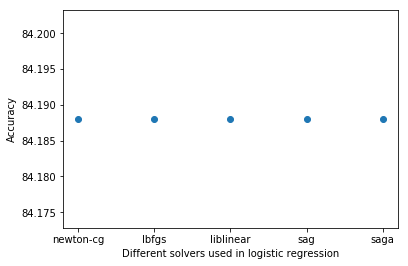

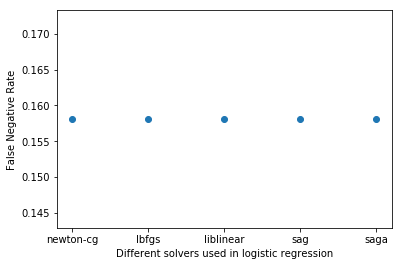

In [28]:
#Logistic regression using inbuilt class
import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_wo_pca_scores = []
log_wo_pca_fnr = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_wo_pca_scores.append(accuracy_score(y_test, y_pred)*100)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    log_wo_pca_fnr.append(fn/len(y_test))

LogReg_wo_pca_acc = np.array(lg_wo_pca_scores).mean()
LogReg_wo_pca_fnr = np.array(log_wo_pca_fnr).mean()
print("Accuracies from cross validation ",np.array(lg_wo_pca_scores))
print("False negative rates from cross validation", np.array(log_wo_pca_fnr))
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
fnr_solvers = []
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores_solvers.append(accuracy_score(y_test, y_pred)*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnr_solvers.append(fn/len(y_test))
plt.scatter(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()

plt.scatter(solvers, fnr_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('False Negative Rate')
plt.show()

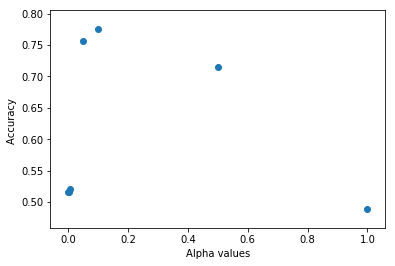

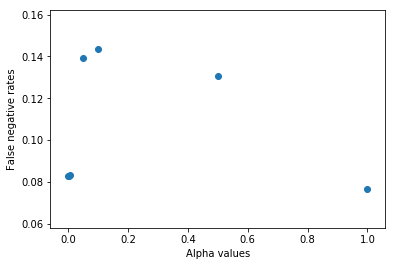

[76.02295674 78.28143267 79.12105431 79.95536189 79.54617919 80.05632905
 81.26793496 77.95196089 75.1833351  72.47316399]
[0.14023806993304283, 0.14124774152407268, 0.14650866191943884, 0.13901583590179614, 0.1523541290254012, 0.15432033159740674, 0.14390477202678287, 0.13752789882027847, 0.14215113189499415, 0.14007864810288023]


In [11]:
#Implementation of logistic regression
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_wo_pca_scores = []

def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def cost(theta, X, y):
    c = 0
    for i in range(len(X)):
        temp = hypothesis(theta, X[i])
        c = c + (-y[i]* np.log(temp) - (1-y[i])*np.log(1-temp)) 
    return c/len(X)
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta, alpha):
    num_iter = 250
    for i in range(num_iter):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test,alpha=0.1):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta,alpha)
    y_pred = predict(theta,X_test)
    return theta,y_pred
a_scores = []
a_fnr = []
alphas = [0.1,0.001, 0.0001, 0.5,0.05,0.005, 1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for alpha in alphas:
    theta, y_pred = logistic_reg(X_train,y_train, X_test,alpha)
    a_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    a_fnr.append(fn/len(y_test))

plt.scatter(alphas, a_scores)
plt.xlabel("Alpha values")
plt.ylabel("Accuracy ")
plt.show()
plt.scatter(alphas, a_fnr)
plt.xlabel("Alpha values")
plt.ylabel("False negative rates")
plt.show()

fnr_scores = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_wo_pca_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_scores.append(fn/len(y_test))
print(np.array(lg_m_wo_pca_scores)*100)
print(fnr_scores)
LogReg_m_wo_pca_acc = (np.array(lg_m_wo_pca_scores)*100).mean()
LogReg_m_wo_pca_fnr = np.array(fnr_scores).mean()

In [16]:
#ANN implementation

import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
ANN_wo_pca_scores = []
fnr_val = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(43, input_shape=(43,),activation='relu'),
        keras.layers.Dense(23, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    tn, fp, fn, tp = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)).ravel()
    ANN_wo_pca_scores.append(score)
    fnr_val.append(fn/len(y_test))
print("Accuracies from ANN",np.array(ANN_wo_pca_scores))
print("False negative rates", np.array(fnr_val))
ANN_wo_pca_acc = np.array(ANN_wo_pca_scores).mean()
ANN_wo_pca_fnr = np.array(fnr_val).mean()

Accuracies from ANN [84.68487618 84.59453715 84.08970135 84.92400893 83.7283452  83.65926241
 84.87618238 84.64236369 83.73897332 83.29790626]
False negative rates [0.15293868 0.15405463 0.15883728 0.15065363 0.16250399 0.16330109
 0.15091933 0.15357636 0.16261027 0.16702094]


In [32]:
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_wo_pca_scores = []
fnr_val = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_train_test):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_val.append(fn/len(y_test))
    linear_svc_wo_pca_scores.append(accuracy_score(y_test, y_pred))
print("Accuracies obtained from cross validation", np.array(linear_svc_wo_pca_scores))
print("False negative rates ", np.array(fnr_val))
linear_svc_wo_pca_acc = np.array(linear_svc_wo_pca_scores).mean()
linear_svc_wo_pca_fnr = np.array(fnr_val).mean()

Accuracies obtained from cross validation [0.84623049 0.84642976 0.84377283 0.84423779 0.84788096 0.83891325
 0.83359904 0.84734954 0.84781453 0.8443603 ]
False negative rates  [0.15370309 0.15323813 0.15596147 0.15576221 0.15211904 0.16108675
 0.16640096 0.15265046 0.15218547 0.1556397 ]


In [21]:
#ANN using PCA
from sklearn.decomposition import PCA
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
ANN_pca_scores = []
fnr_val = []

kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(15, input_shape=(15,),activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    tn, fp, fn, tp = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)).ravel()
    fnr_val.append(fn/len(y_test))
    ANN_pca_scores.append(score)
print("Accuracies from cross validation ",np.array(ANN_pca_scores))
print("False negative rates from cross validation ", np.array(fnr_val))
ANN_pca_acc = np.array(ANN_pca_scores).mean()
ANN_pca_fnr = np.array(fnr_val).mean()

Accuracies from cross validation  [84.6955043  84.52014029 84.11095759 84.92932299 83.74960145 83.61674992
 84.90275268 84.64236369 83.73897332 83.29790626]
False negative rates from cross validation  [0.15293868 0.15384207 0.15889042 0.15065363 0.16250399 0.16319481
 0.15097247 0.15357636 0.16250399 0.16702094]


In [31]:
#Linear svm with PCA
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
fnr_val = []

kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    linear_svc_pca_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_val.append(fn/len(y_test))
print("Accuracies obtained from cross validation", np.array(linear_svc_pca_scores))
print("False negative rates ", np.array(fnr_val))
linear_svc_pca_acc = np.array(linear_svc_pca_scores).mean()
linear_svc_pca_fnr = np.array(fnr_val).mean()

Accuracies obtained from cross validation [0.8469019  0.84589223 0.84105644 0.84934637 0.83749601 0.83669891
 0.84902753 0.8463705  0.83733659 0.83287278]
False negative rates  [0.1530981  0.15405463 0.15889042 0.15060049 0.16250399 0.16330109
 0.15097247 0.15357636 0.16261027 0.16702094]


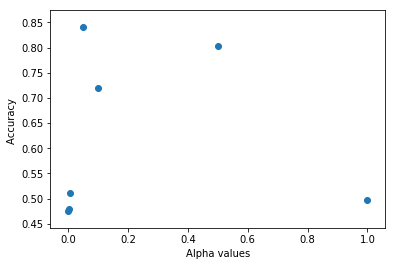

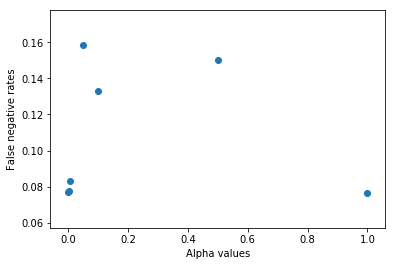

[51.87586353 84.41917313 59.77787225 63.07790413 76.9422893  64.39579126
 83.36698905 84.07907323 69.0509087  61.35083431]
[0.07960463386119673, 0.1535763630566479, 0.10096715910298651, 0.10043575300244446, 0.14560527154851738, 0.11579338930810926, 0.14874056754171538, 0.1523541290254012, 0.12976936975236475, 0.10920395366138803]


In [37]:
#Implementation of logistic regression with PCA
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def cost(theta, X, y):
    c = 0
    for i in range(len(X)):
        temp = hypothesis(theta, X[i])
        c = c + (-y[i]* np.log(temp) - (1-y[i])*np.log(1-temp)) 
    return c/len(X)
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta, alpha):
    num_iter = 350
    for i in range(num_iter):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test,alpha=0.1):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta,alpha)
    y_pred = predict(theta,X_test)
    return theta,y_pred
a_scores = []
a_fnr = []
alphas = [0.1,0.001, 0.0001, 0.5,0.05,0.005, 1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for alpha in alphas:
    theta, y_pred = logistic_reg(X_train,y_train, X_test,alpha)
    a_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    a_fnr.append(fn/len(y_test))

plt.scatter(alphas, a_scores)
plt.xlabel("Alpha values")
plt.ylabel("Accuracy ")
plt.show()
plt.scatter(alphas, a_fnr)
plt.xlabel("Alpha values")
plt.ylabel("False negative rates")
plt.show()

fnr_scores = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_pca_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_scores.append(fn/len(y_test))
print(np.array(lg_m_pca_scores)*100)
print(fnr_scores)
LogReg_m_pca_acc = (np.array(lg_m_pca_scores)*100).mean()
LogReg_m_pca_fnr = np.array(fnr_scores).mean()


Accuracies from cross validation  [84.69019024 84.57859496 84.09501541 84.92400893 83.73897332 83.66457647
 84.90275268 84.63704963 83.73365926 83.28727814]
False negative rates from cross validation [0.1530981  0.15405463 0.15889042 0.15060049 0.16245084 0.16330109
 0.15097247 0.15357636 0.16261027 0.16702094]


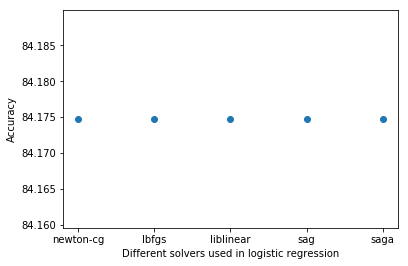

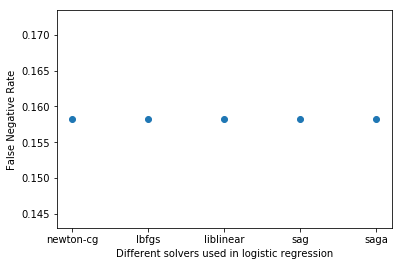

In [27]:
#Logistic regression using inbuilt class with PCA
import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_wo_pca_scores = []
log_wo_pca_fnr = []
kf  = KFold(n_splits=10)
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_wo_pca_scores.append(accuracy_score(y_test, y_pred)*100)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    log_wo_pca_fnr.append(fn/len(y_test))

LogReg_pca_acc = np.array(lg_wo_pca_scores).mean()
LogReg_pca_fnr = np.array(log_wo_pca_fnr).mean()
print("Accuracies from cross validation ",np.array(lg_wo_pca_scores))
print("False negative rates from cross validation", np.array(log_wo_pca_fnr))
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
fnr_solvers = []
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores_solvers.append(accuracy_score(y_test, y_pred)*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnr_solvers.append(fn/len(y_test))
plt.scatter(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()

plt.scatter(solvers, fnr_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('False Negative Rate')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

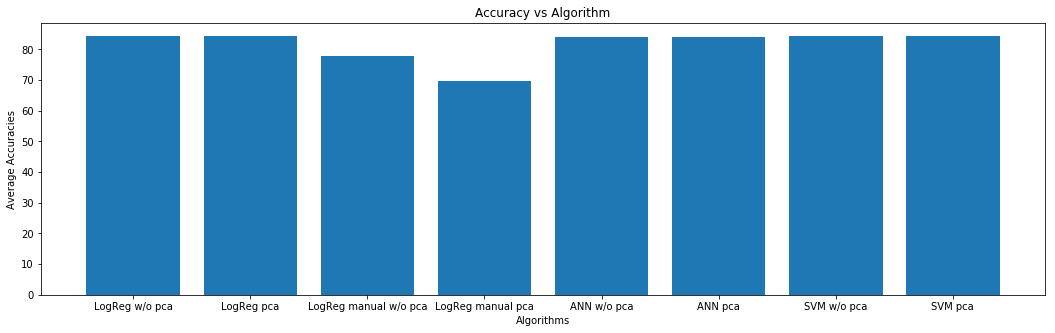

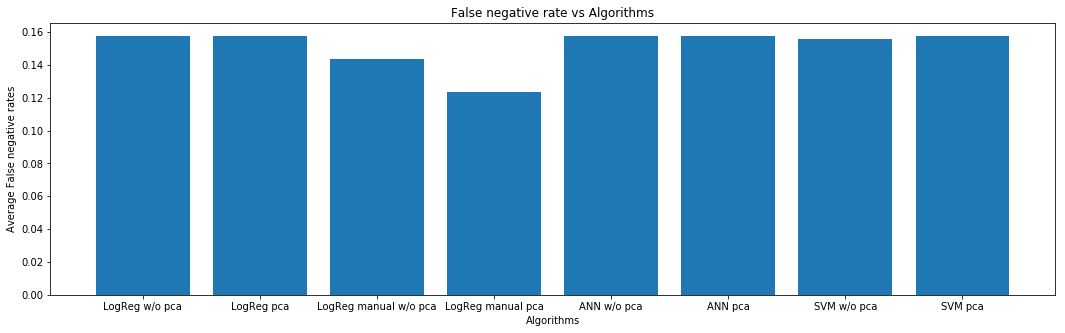

In [38]:
acc = [LogReg_wo_pca_acc, LogReg_pca_acc, LogReg_m_wo_pca_acc, LogReg_m_pca_acc, ANN_wo_pca_acc, ANN_pca_acc, linear_svc_wo_pca_acc*100,linear_svc_pca_acc*100]
fnr = [LogReg_wo_pca_fnr, LogReg_pca_fnr, LogReg_m_wo_pca_fnr, LogReg_m_pca_fnr, ANN_wo_pca_fnr, ANN_pca_fnr, linear_svc_wo_pca_fnr,linear_svc_pca_fnr]
algos = ["LogReg w/o pca", "LogReg pca", "LogReg manual w/o pca", "LogReg manual pca", "ANN w/o pca", "ANN pca", "SVM w/o pca", "SVM pca"]
plt.figure(figsize=(18,5))
plt.title("Accuracy vs Algorithm")
plt.bar(algos, acc)
plt.xlabel("Algorithms")
plt.ylabel("Average Accuracies")
plt.show

plt.figure(figsize=(18,5))
plt.title("False negative rate vs Algorithms")
plt.bar(algos, fnr)
plt.xlabel("Algorithms")
plt.ylabel("Average False negative rates")
plt.show

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
kmeans_scores = []
kmeans_fnr = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X[0]
    kmeans = KMeans(n_clusters=2, precompute_distances='auto').fit(X_train)
    pred = kmeans.predict(s.reshape(1,-1))
    y_pred = kmeans.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        kmeans_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        kmeans_fnr.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        kmeans_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        kmeans_fnr.append(fn/len(y_test))

print("Accuracies from cross validation",np.array(kmeans_scores))
print("False negative rates",np.array(kmeans_fnr))
kmeans_wo_pca_acc = np.array(kmeans_scores).mean()
kmeans_wo_pca_fnr = np.array(kmeans_fnr).mean()

Accuracies from cross validation [59.02327559 59.26772239 59.32617706 60.25613774 60.42618769 58.84259751
 58.12519928 60.47401424 65.43734722 66.3938782 ]
False negative rates [0.0961845  0.0543097  0.09953236 0.10059517 0.0557445  0.05829525
 0.09453715 0.05213094 0.04075885 0.12387076]


In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
mbkm_scores = []
mbkm_fnr = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X[0]
    mbkm = MiniBatchKMeans(n_clusters=2).fit(X_train)
    pred = mbkm.predict(s.reshape(1,-1))
    y_pred = mbkm.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
print("Accuracies from cross validation",np.array(mbkm_scores))
print("False negative rates",np.array(mbkm_fnr))

mbkm_wo_pca_acc = np.array(mbkm_scores).mean()
mbkm_wo_pca_fnr = np.array(mbkm_fnr).mean()

Accuracies from cross validation [58.33244766 57.55128069 55.21840791 61.97257945 62.15325752 61.95663726
 61.27112339 62.45084494 67.44074822 69.11467744]
False negative rates [0.05314061 0.09623764 0.09012647 0.04596663 0.11170156 0.11255181
 0.04931449 0.10553725 0.12689978 0.03661388]


In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
kmeans_scores = []
kmeans_fnr = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X_pca[0]
    kmeans = KMeans(n_clusters=2, precompute_distances='auto').fit(X_train)
    pred = kmeans.predict(s.reshape(1,-1))
    y_pred = kmeans.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        kmeans_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        kmeans_fnr.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        kmeans_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        kmeans_fnr.append(fn/len(y_test))
print("Accuracies from cross validation",np.array(kmeans_scores))
print("False negative rates",np.array(kmeans_fnr))
kmeans_pca_acc = np.array(kmeans_scores).mean()
kmeans_pca_fnr = np.array(kmeans_fnr).mean()

Accuracies from cross validation [59.00201934 59.40588798 59.38463174 60.43681581 60.44212988 58.82134127
 58.27930705 60.48464236 65.49048783 66.49484536]
False negative rates [0.09671591 0.05399086 0.09979807 0.1007546  0.05553194 0.05824211
 0.09474971 0.05213094 0.04054629 0.12418961]


In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
mbkm_scores = []
mbkm_fnr = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X_pca[0]
    mbkm = MiniBatchKMeans(n_clusters=2).fit(X_train)
    pred = mbkm.predict(s.reshape(1,-1))
    y_pred = mbkm.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
print("Accuracies from cross validation",np.array(mbkm_scores))
print("False negative rates",np.array(mbkm_fnr))

mbkm_pca_acc = np.array(mbkm_scores).mean()
mbkm_pca_fnr = np.array(mbkm_fnr).mean()

Accuracies from cross validation [52.69954299 58.00297587 60.21893931 61.26580933 60.98947816 63.13635881
 59.16144117 59.0764162  69.6513976  68.3972792 ]
False negative rates [0.06669147 0.05654161 0.10197683 0.10218939 0.05409714 0.1146243
 0.05415028 0.10006377 0.1309916  0.128494  ]


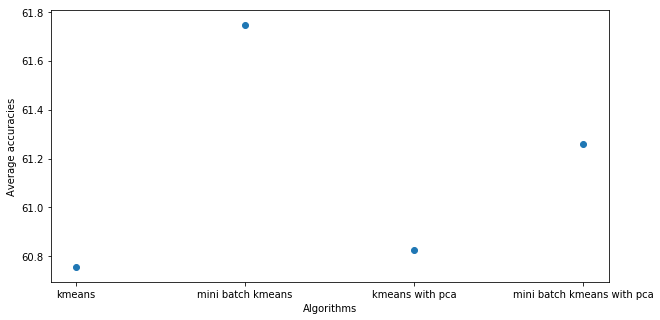

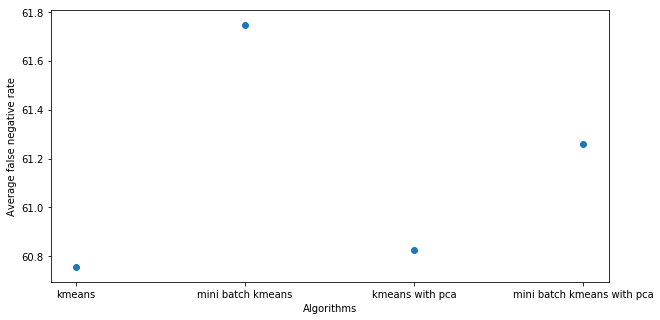

In [43]:
from matplotlib import pyplot as plt
algos = ["kmeans", "mini batch kmeans", "kmeans with pca", "mini batch kmeans with pca"]
acc = [kmeans_wo_pca_acc, mbkm_wo_pca_acc, kmeans_pca_acc, mbkm_pca_acc]
fnr = [kmeans_wo_pca_fnr, mbkm_wo_pca_fnr, kmeans_pca_fnr,  mbkm_pca_fnr]

plt.figure(figsize=(10,5))
plt.scatter(algos, acc)
plt.xlabel("Algorithms")
plt.ylabel("Average accuracies")
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(algos, acc)
plt.xlabel("Algorithms")
plt.ylabel("Average false negative rate")
plt.show()